# CNN Cancer Detection

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models

In [2]:
# Ubuntu setting
from os import environ
environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [3]:
# Check if GPU is used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## I. Brief Introduction

* Goal:

    The primary goal of this project is to <u>__predict if tumors are on small pathology images__</u>. A positive label indicates that the center 32 x 32px region of a patch contains at least one pixel of tumor tissue.

* Data description

    1. Data for training and testing is named with an image ID, and we have 220,025 images for training, and 57,458 images for testing.

    2. In order to evaluate the model's performance during training, I will spilt 20% of the training dataset as validation dataset, so there are 176,020 images for training, and 44,005 images for validation.

    3. The format of the pathology images is _tiff_, which is not a supported format by Keras' `image_dataset_from_directory()` function. To load and decode the images by Keras, `tensorflow-io` packages is needed.

    4. Utilizing Keras' `Dataset` can greatly improve the efficiency of processing the images, such as loading, normalization and so on. If we just load the images using `OpenCV` or `Pillow` one by one, the computer will easily crash. 

## II. EDA

### Load

In [ ]:
# Packages
import os, shutil

# Training data
# original_dir = Path.home() /'Desktop/dogs-vs-cats/train'
# New dir for selected data for training
# new_base_dir = Path.home() /'Desktop/dogs-vs-cats/cats_vs_dogs_small'

def make_subset(subset_name, start_index, end_index):

    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        # Select training data
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        # Copy training data
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst = dir / fname)

# Training dataset
make_subset('train', start_index=0, end_index=1000)
# Validation dataset
make_subset('validation', start_index=1000, end_index=1500)
# Test dataset
make_subset('test', start_index=1500, end_index=2500)

In [2]:
# Set CWD
# Ubuntu
# cwd = Path.home() /'Desktop/CNN/CNN/train/'
# MacOS

# Get training and test images path
train_ds_path = Path.home() /'Desktop/CNN/train/'
img_path = [i.as_posix() for i in train_ds_path.glob('*.tif')]
# Create a dataframe to store the info of training images
df_train = pd.DataFrame({'path' : img_path})
df_train['id'] = df_train['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
# Test dataset
test_ds_path = Path.home() /'Desktop/CNN/test/'
test_img_path = [i.as_posix() for i in test_ds_path.glob('*.tif')]
print('Number of training images:', len(img_path))
print('Number of training images:', len(test_img_path))

Number of training images: 220025
Number of training images: 57458


In [3]:
# Training labels
# Ubuntu
# df_labels = pd.read_csv('/home/ivan/Desktop/CNN/CNN/train_labels.csv')

# Load training labels
df_labels = pd.read_csv((Path.home() /'Desktop/CNN/train_labels.csv').as_posix())
# Match image ID to get labels
df_train = pd.merge(df_train, df_labels, on = 'id')
# Data preview
df_train.head()

,path,id,label
0,C:/Users/ordin/Desktop/CNN/train/00001b2b5609a...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,C:/Users/ordin/Desktop/CNN/train/000020de2aa61...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,C:/Users/ordin/Desktop/CNN/train/00004aab08381...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,C:/Users/ordin/Desktop/CNN/train/0000d563d5cfa...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,C:/Users/ordin/Desktop/CNN/train/0000da768d06b...,0000da768d06b879e5754c43e2298ce48726f722,1


In [5]:
# Images with / without tumors
df_train['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

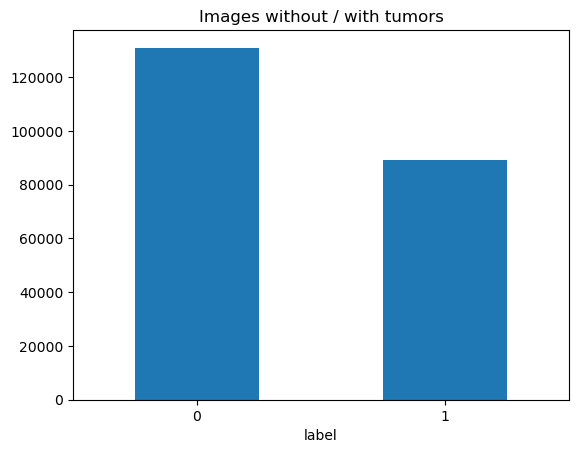

In [6]:
df_train['label'].value_counts().plot(kind = 'bar', title = 'Images without / with tumors', rot = 0);

* From the plot, we can see that the positive and negative images are sort of imbalance, so <u>__stratified strategy might be needed when splitting the training and validating data__</u>.

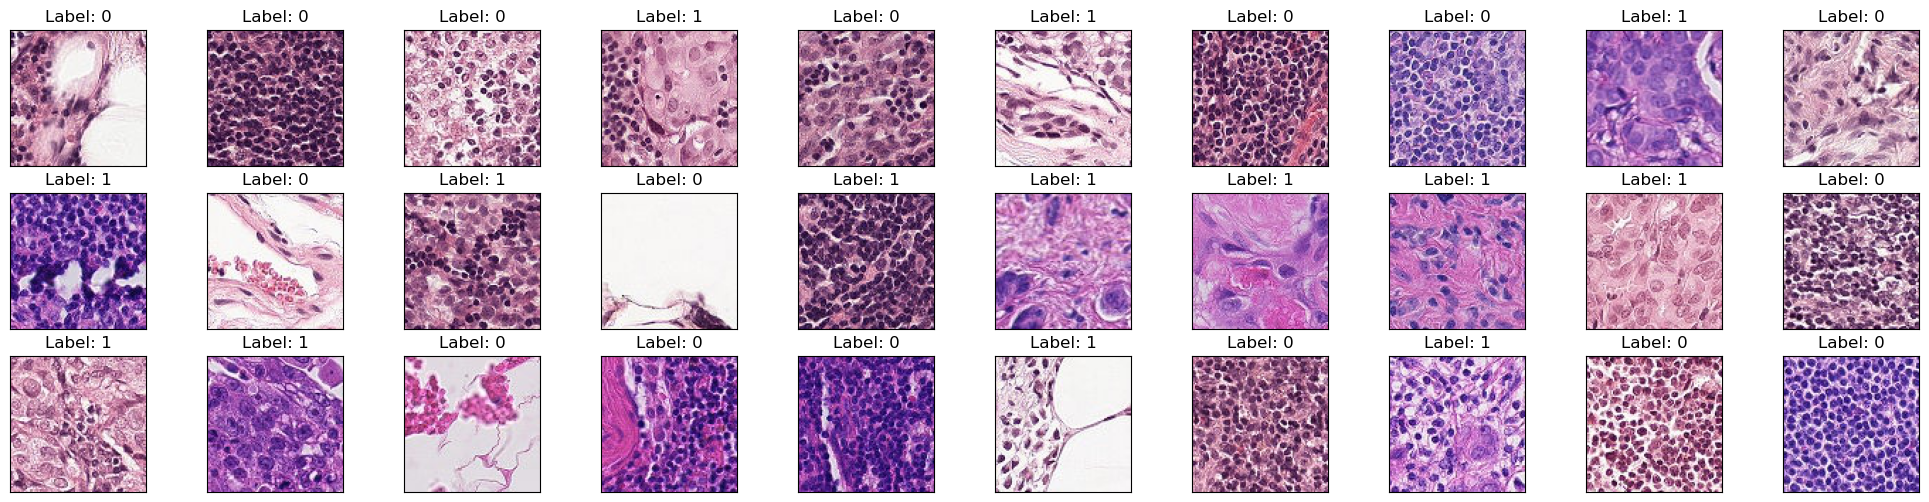

In [13]:
# Display 30 images
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(img_path, 30)):
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    im = Image.open(img)
    plt.imshow(im)
    lab = df_train.loc[df_train['id'] == img.split('/')[-1].split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

* By observing the differences between the images with and without tumor, there seem to be some irregular rounded or strange shapes if tumors exist. However, more medical knowledge is needed to back my observation, but we can utilize deep learning techniques to teach computers and help us identify if there are tumors on pathology images. 

* With this simple EDA, we know a little more about the dataset. Since the input data are all image arrays and without any other feature, data cleaning is not needed to be implemented, but image-related preprocessed would be carried out instead in the next section.

## Data Preprocessing

* In this section, we will utilize the Tensorflow `Dataset` object to build high-performance input pipeline, and load the training dataset, without worrying about computer crash. On the other hand, I also bind the __standardization__ and __data augmentation__ in the data input pipeline, which can all be finished in a short time with the help of the Tensorflow Dataset object. I was heavily inspired by this [<u>blog</u>](https://cs230.stanford.edu/blog/datapipeline/#goals-of-this-tutorial) and some techniques implemented in this notebook are from the blog.

### Create Tensorflow dataset

In [4]:
image_count = len(img_path)
test_image_count = len(test_img_path)
print("Number of training images:", image_count)
print("Number of test images:", test_image_count)


Number of training images: 220025
Number of test images: 57458


In [5]:
# Parse the images from filename to the pixel values
def parse_function(file_name, label):

    # Read the content of the file
    img_string = tf.io.read_file(file_name)
    # Decode tiff image
    img = tfio.experimental.image.decode_tiff(img_string)
    # Since decode_tiff() returns RGBA tensor, and we only need 3 channel, we just extract RGB from the tensor
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    # Combine RGB together
    img = tf.stack([r, g, b], axis = -1) # -1 means last dimension
    # Standardize, convert to float values in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, label

# Data augmentation for the images
def data_augmentation(image, label):
    
    # Horizontally flip the image with probability 1/2
    image = tf.image.random_flip_left_right(image)

    # Apply random brightness and saturation
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [38]:
df_train['path'].values.shape

(220025,)

In [ ]:
list_ds = tf.data.Dataset.list_files(df_train['path'].values)

In [45]:
dataset.map(parse_function)

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
### Building an image data pipeline

# Create the dataset from slices of the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['label'].values))
# Shuffle the data with a buffer size equal to the length of the dataset. This ensures good shuffling
dataset = dataset.shuffle(image_count)

# Train / validation set split
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

## Training dataset
# Parse the images from filename to the pixel values.
train_ds = train_ds.map(parse_function, num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
# Data augmentation
# train_ds = train_ds.map(data_augmentation, num_parallel_calls = 4)

## Validation dataset
# Parse the images from filename to the pixel values.
val_ds = val_ds.map(parse_function, num_parallel_calls=4) 
# Data augmentation
# val_ds = val_ds.map(data_augmentation, num_parallel_calls = 4)

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(train_ds).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds).numpy()
train_batch_size = 32
val_batch_size = 32
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")

Number of training images: 176020
Number of validation images: 44005


In [27]:
# Image data shape
for data, label in train_ds.take(1):
    print(data.shape)

(96, 96, 3)


In [ ]:
# Create test dataset for evaluation
dataset = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['label'].values))
test_ds = dataset.take(val_size)
test_ds = test_ds.batch(1)
test_ds = test_ds.prefetch(1)
test_ds = test_ds.map(parse_function, num_parallel_calls=4)
num_test_samples = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Test data shape: {num_test_samples}")

## Modeling

In [11]:
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
# from keras.layers import Conv2D, MaxPool2D
# from keras.optimizers import RMSprop#, Adam
# from tensorflow.keras.optimizers.legacy import Adam # To avoid running pretty slow on Mac M1/M2

### First model

* The first model is designed as a base model without applying any technique to the model or the training data so that we can see how CNN performs to solve the problem and what we can do.

* Model structure:

    - Input
    - [Conv2D -> MaxPool2D] x 3 --> (filters = 32, 64, 128)
    - Flatten
    - Dense (256)
    - Output

In [17]:
inputs = keras.Input(shape = (96, 96, 3))
# Rescale the image data
x = layers.Rescaling(1./255)(inputs)
# CNN structure
x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'model_0')
print(model.summary())

Model: "model_0"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 

In [18]:
# Model Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='cancer_dectection_model_0.keras_',
        save_best_only=True,
        monitor='val_loss'), 
]

# Training the model
history = model.fit(
    train_ds.batch(32),
    epochs=15,
    validation_data=val_ds.batch(32),
    callbacks=callbacks
)

Epoch 1/15
5495/5501 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.5949

INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


5501/5501 [==============================] - 57s 10ms/step - loss: 0.6758 - accuracy: 0.5949 - val_loss: 0.6747 - val_accuracy: 0.5967
Epoch 2/15
5496/5501 [============================>.] - ETA: 0s - loss: 0.6750 - accuracy: 0.5953

INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


5501/5501 [==============================] - 57s 10ms/step - loss: 0.6750 - accuracy: 0.5953 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 3/15
5501/5501 [==============================] - 57s 10ms/step - loss: 0.6749 - accuracy: 0.5959 - val_loss: 0.6753 - val_accuracy: 0.5950
Epoch 4/15
5498/5501 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.5949

INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


5501/5501 [==============================] - 60s 11ms/step - loss: 0.6752 - accuracy: 0.5949 - val_loss: 0.6745 - val_accuracy: 0.5964
Epoch 5/15
5501/5501 [==============================] - 59s 11ms/step - loss: 0.6752 - accuracy: 0.5949 - val_loss: 0.6750 - val_accuracy: 0.5950
Epoch 6/15
5501/5501 [==============================] - 59s 11ms/step - loss: 0.6751 - accuracy: 0.5952 - val_loss: 0.6747 - val_accuracy: 0.5959
Epoch 7/15
5501/5501 [==============================] - 59s 11ms/step - loss: 0.6752 - accuracy: 0.5949 - val_loss: 0.6750 - val_accuracy: 0.5949
Epoch 8/15
5501/5501 [==============================] - 60s 11ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6752 - val_accuracy: 0.5950
Epoch 9/15
5501/5501 [==============================] - 61s 11ms/step - loss: 0.6750 - accuracy: 0.5953 - val_loss: 0.6752 - val_accuracy: 0.5945
Epoch 10/15
5501/5501 [==============================] - 60s 11ms/step - loss: 0.6749 - accuracy: 0.5954 - val_loss: 0.6753 - val_accur

INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_0.keras_\assets


5501/5501 [==============================] - 60s 11ms/step - loss: 0.6751 - accuracy: 0.5950 - val_loss: 0.6740 - val_accuracy: 0.5979
Epoch 12/15
5501/5501 [==============================] - 61s 11ms/step - loss: 0.6750 - accuracy: 0.5954 - val_loss: 0.6752 - val_accuracy: 0.5949
Epoch 13/15
5501/5501 [==============================] - 62s 11ms/step - loss: 0.6749 - accuracy: 0.5956 - val_loss: 0.6751 - val_accuracy: 0.5946
Epoch 14/15
5501/5501 [==============================] - 60s 11ms/step - loss: 0.6749 - accuracy: 0.5956 - val_loss: 0.6767 - val_accuracy: 0.5913
Epoch 15/15
5501/5501 [==============================] - 60s 11ms/step - loss: 0.6752 - accuracy: 0.5950 - val_loss: 0.6762 - val_accuracy: 0.5932


In [19]:
# Model evaluation
print("Model 0")
print(f"Accuracy : {history.history['accuracy']}")
print(f"Val accuracy : {history.history['val_accuracy']}")

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Model 0
Accuracy : [0.594852864742279, 0.5952959656715393, 0.595869779586792, 0.5948926210403442, 0.5949323773384094, 0.5952448844909668, 0.5949153304100037, 0.594659686088562, 0.5953357815742493, 0.5954493880271912, 0.5949721336364746, 0.5954323410987854, 0.5955743789672852, 0.5955686569213867, 0.5949891805648804]
Val accuracy : [0.5967276692390442, 0.5961140990257263, 0.5949551463127136, 0.5964094996452332, 0.594977855682373, 0.5959095358848572, 0.59490966796875, 0.594977855682373, 0.5944778919219971, 0.5944551825523376, 0.5979320406913757, 0.5949323773384094, 0.5946369767189026, 0.5913419127464294, 0.5932053327560425]


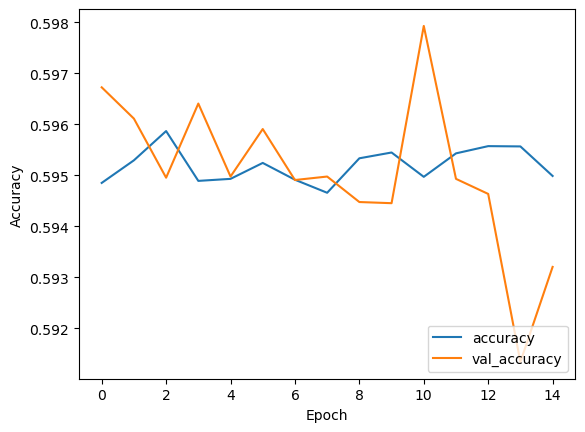

In [20]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

### Second model

* From the result of the first model we can see that it seemed to reach a bottleneck because neither loss nor accuracy didn't improve. The learning was stuck and a good method to deal with this is adjusting the learning rate. Thus, I apply two callback techniques by using `ReduceLROnPlateau` and `EarlyStopping` from `keras.callback` class. `ReduceLROnPlateau` will reduce the learning rate while training according to the monitor we set. `EarlyStopping` will stop the training process when the monitoring metrics has stopped improving.

    For more information, you can read the Tensorflow documentation

    [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
    
    [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

* Model structure:

    - Input
    - [Conv2D -> MaxPool2D] x 3 --> (filters = 32, 64, 128)
    - Flatten
    - Dense (256)
    - Output

In [13]:
inputs = keras.Input(shape = (96, 96, 3))
# Rescale the image data
x = layers.Rescaling(1./255)(inputs)
# CNN structure
x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'First_model')
print(model.summary())

Model: "First_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                   

In [14]:
# Model Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])


# Define callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='cancer_dectection_model_1.keras_',
        save_best_only=True,
        monitor='val_loss'), 
    earlystopper,
    reducel
]

# Training the model
history = model.fit(
    train_ds.batch(32),
    epochs=30,
    validation_data=val_ds.batch(32),
    callbacks=callbacks
)

Epoch 1/30
5500/5501 [============================>.] - ETA: 0s - loss: 0.5707 - accuracy: 0.7017

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 59s 11ms/step - loss: 0.5707 - accuracy: 0.7017 - val_loss: 0.4920 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 2/30
5497/5501 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.7613
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5501/5501 [==============================] - 58s 10ms/step - loss: 0.5010 - accuracy: 0.7613 - val_loss: 0.5265 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 3/30
5499/5501 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.7906

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 59s 11ms/step - loss: 0.4564 - accuracy: 0.7906 - val_loss: 0.4524 - val_accuracy: 0.7910 - lr: 1.0000e-04
Epoch 4/30
5499/5501 [============================>.] - ETA: 0s - loss: 0.4501 - accuracy: 0.7928

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 60s 11ms/step - loss: 0.4501 - accuracy: 0.7928 - val_loss: 0.4456 - val_accuracy: 0.7977 - lr: 1.0000e-04
Epoch 5/30
5499/5501 [============================>.] - ETA: 0s - loss: 0.4469 - accuracy: 0.7957

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 61s 11ms/step - loss: 0.4469 - accuracy: 0.7957 - val_loss: 0.4442 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 6/30
5497/5501 [============================>.] - ETA: 0s - loss: 0.4456 - accuracy: 0.7961

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 61s 11ms/step - loss: 0.4456 - accuracy: 0.7961 - val_loss: 0.4406 - val_accuracy: 0.7997 - lr: 1.0000e-04
Epoch 7/30
5500/5501 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.7965
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5501/5501 [==============================] - 62s 11ms/step - loss: 0.4445 - accuracy: 0.7965 - val_loss: 0.4426 - val_accuracy: 0.7972 - lr: 1.0000e-04
Epoch 8/30
5497/5501 [============================>.] - ETA: 0s - loss: 0.4382 - accuracy: 0.8000

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 61s 11ms/step - loss: 0.4382 - accuracy: 0.8000 - val_loss: 0.4391 - val_accuracy: 0.8001 - lr: 1.0000e-05
Epoch 9/30
5498/5501 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.8000

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 61s 11ms/step - loss: 0.4378 - accuracy: 0.8000 - val_loss: 0.4366 - val_accuracy: 0.8008 - lr: 1.0000e-05
Epoch 10/30
5500/5501 [============================>.] - ETA: 0s - loss: 0.4391 - accuracy: 0.7988
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
5501/5501 [==============================] - 60s 11ms/step - loss: 0.4391 - accuracy: 0.7988 - val_loss: 0.4410 - val_accuracy: 0.7972 - lr: 1.0000e-05
Epoch 11/30
5496/5501 [============================>.] - ETA: 0s - loss: 0.4375 - accuracy: 0.8001

INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_1.keras_\assets


5501/5501 [==============================] - 60s 11ms/step - loss: 0.4375 - accuracy: 0.8002 - val_loss: 0.4351 - val_accuracy: 0.8019 - lr: 1.0000e-06
Epoch 12/30
5497/5501 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.7995
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
5501/5501 [==============================] - 59s 11ms/step - loss: 0.4379 - accuracy: 0.7995 - val_loss: 0.4363 - val_accuracy: 0.8005 - lr: 1.0000e-06
Epoch 13/30
5498/5501 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.7993Restoring model weights from the end of the best epoch: 11.

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
5501/5501 [==============================] - 60s 11ms/step - loss: 0.4381 - accuracy: 0.7993 - val_loss: 0.4372 - val_accuracy: 0.8014 - lr: 1.0000e-07
Epoch 13: early stopping


In [16]:
# Model evaluation
print("Model 1")
print(f"Accuracy : {history.history['accuracy']}")
print(f"Val accuracy : {history.history['val_accuracy']}")

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Model 1
Accuracy : [0.7017270922660828, 0.7612600922584534, 0.7905806303024292, 0.7928019762039185, 0.7956936955451965, 0.7960913777351379, 0.7964720129966736, 0.7999886274337769, 0.7999886274337769, 0.7988012433052063, 0.8001761436462402, 0.7994943857192993, 0.799289882183075]
Val accuracy : [0.7722304463386536, 0.734643816947937, 0.7909783124923706, 0.7977275252342224, 0.7975003123283386, 0.7997045516967773, 0.7971821427345276, 0.800068199634552, 0.8008407950401306, 0.7971821427345276, 0.8018861413002014, 0.8004999160766602, 0.8014089465141296]


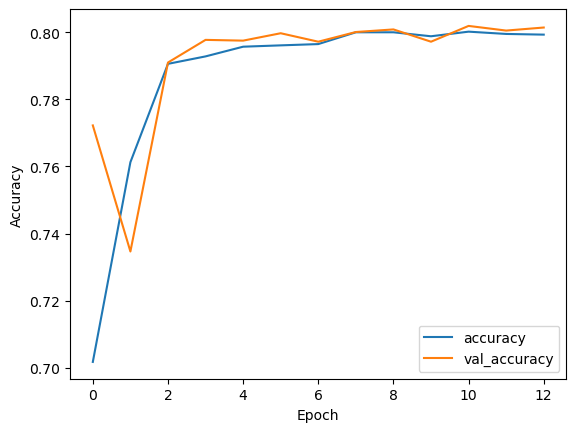

In [ ]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

### Third model

* Apply data augmentation to see if the results has improved, and also add one more layer and a dropout layer.

* Model structure (optimizer: RMSprop):

    - Input
    - [Conv2D -> MaxPool2D] x4 --> (filters = 32, 64, 128, 256)
    - Flatten
    - Dense (256)
    - Dropout(.5)
    - Output

In [21]:
inputs = keras.Input(shape = (96, 96, 3))
# Rescale the image data
x = layers.Rescaling(1./255)(inputs)
# CNN structure
x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(.5)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Third_model')
print(model.summary())

Model: "Third_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                  

In [22]:
# Model Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


# Define callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='cancer_dectection_model_3.keras_',
        save_best_only=True,
        monitor='val_loss'), 
    earlystopper,
    reducel
]

# Training the model
history = model.fit(
    train_ds.batch(32),
    epochs=15,
    validation_data=val_ds.batch(32),
    callbacks=callbacks
)

Epoch 1/15
5501/5501 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5956

INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


5501/5501 [==============================] - 61s 11ms/step - loss: 0.6754 - accuracy: 0.5956 - val_loss: 0.6750 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 2/15
5497/5501 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.5951

INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


5501/5501 [==============================] - 62s 11ms/step - loss: 0.6753 - accuracy: 0.5951 - val_loss: 0.6749 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 3/15
5498/5501 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.5950
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5501/5501 [==============================] - 62s 11ms/step - loss: 0.6751 - accuracy: 0.5950 - val_loss: 0.6768 - val_accuracy: 0.5908 - lr: 0.0010
Epoch 4/15
5498/5501 [============================>.] - ETA: 0s - loss: 0.6749 - accuracy: 0.5954

INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3.keras_\assets


5501/5501 [==============================] - 66s 12ms/step - loss: 0.6749 - accuracy: 0.5954 - val_loss: 0.6747 - val_accuracy: 0.5957 - lr: 1.0000e-04
Epoch 5/15
5495/5501 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.5956
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5501/5501 [==============================] - 65s 12ms/step - loss: 0.6748 - accuracy: 0.5956 - val_loss: 0.6759 - val_accuracy: 0.5927 - lr: 1.0000e-04
Epoch 6/15
5499/5501 [============================>.] - ETA: 0s - loss: 0.6750 - accuracy: 0.5951Restoring model weights from the end of the best epoch: 4.

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
5501/5501 [==============================] - 64s 12ms/step - loss: 0.6750 - accuracy: 0.5951 - val_loss: 0.6758 - val_accuracy: 0.5928 - lr: 1.0000e-05
Epoch 6: early stopping


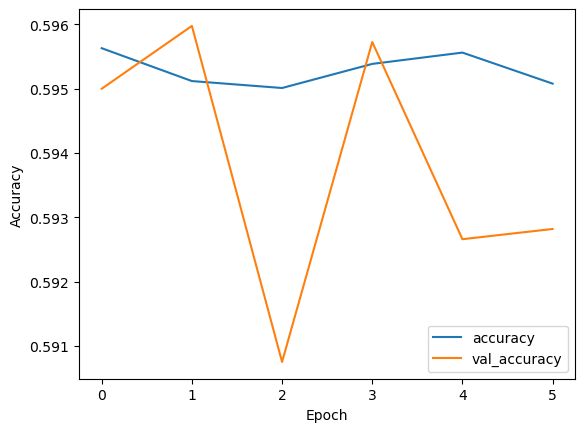

In [23]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [24]:
inputs = keras.Input(shape = (96, 96, 3))
# Rescale the image data
x = layers.Rescaling(1./255)(inputs)
# CNN structure
x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters = 256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(.5)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Third_model_1')
print(model.summary())

Model: "Third_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                

In [25]:
# Model Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])


# Define callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='cancer_dectection_model_3_1.keras_',
        save_best_only=True,
        monitor='val_loss'), 
    earlystopper,
    reducel
]

# Training the model
history = model.fit(
    train_ds.batch(32),
    steps_per_epoch=train_steps, 
    epochs=15,
    validation_data=val_ds.batch(32),
    callbacks=callbacks,
    validation_steps=val_steps
)

Epoch 1/15


5498/5501 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.5949

INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


5501/5501 [==============================] - 66s 12ms/step - loss: 0.6759 - accuracy: 0.5949 - val_loss: 0.6755 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 2/15
5501/5501 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.5944

INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


5501/5501 [==============================] - 68s 12ms/step - loss: 0.6755 - accuracy: 0.5944 - val_loss: 0.6743 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 3/15
5498/5501 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.5945

INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_3_1.keras_\assets


5501/5501 [==============================] - 71s 13ms/step - loss: 0.6755 - accuracy: 0.5945 - val_loss: 0.6730 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 4/15
5498/5501 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.5948
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5501/5501 [==============================] - 69s 12ms/step - loss: 0.6753 - accuracy: 0.5948 - val_loss: 0.6759 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 5/15
5497/5501 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.5946Restoring model weights from the end of the best epoch: 3.

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5501/5501 [==============================] - 73s 13ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6739 - val_accuracy: 0.5978 - lr: 1.0000e-04
Epoch 5: early stopping


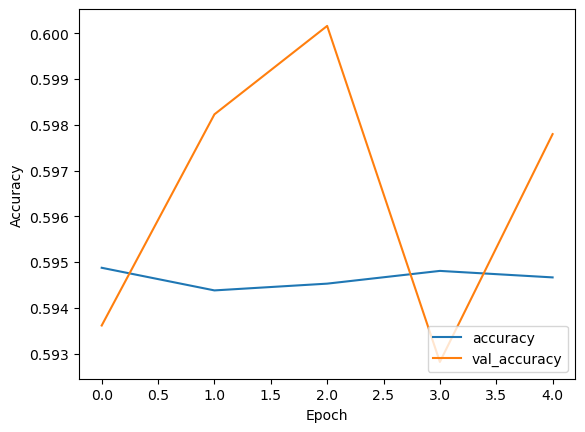

In [26]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

### Fourth model

* [Inspired by](https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

* Define the model
    Model structure (optimizer: Adam):

    - Input
    - [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 32, 64, 128)
    - Flatten
    - Dense (256)
    - Dropout
    - Output

In [27]:
inputs = keras.Input(shape = (96, 96, 3))
# Rescale the image data
x = layers.Rescaling(1./255)(inputs)
# CNN structure
x = keras.layers.Conv2D(filters = 32, kernel_size=3, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Dropout(.3)(x)

x = keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Dropout(.3)(x)

x = keras.layers.Conv2D(filters = 128, kernel_size=3, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Dropout(.3)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(.5)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Fourth_model')
print(model.summary())

Model: "Fourth_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 47, 47, 32)       

In [28]:
# Model Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])


# Define callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='cancer_dectection_model_4.keras_',
        save_best_only=True,
        monitor='val_loss'), 
    earlystopper,
    reducel
]

# Training the model
history = model.fit(
    train_ds.batch(32),
    steps_per_epoch=train_steps, 
    epochs=20,
    validation_data=val_ds.batch(32),
    callbacks=callbacks,
    validation_steps=val_steps
)

Epoch 1/20
5500/5501 [============================>.] - ETA: 0s - loss: 0.5217 - accuracy: 0.7833

INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


5501/5501 [==============================] - 93s 17ms/step - loss: 0.5217 - accuracy: 0.7833 - val_loss: 64.3344 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 2/20
5501/5501 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8076
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4478 - accuracy: 0.8076 - val_loss: 523.8523 - val_accuracy: 0.5942 - lr: 0.0010
Epoch 3/20
5498/5501 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8322

INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


5501/5501 [==============================] - 94s 17ms/step - loss: 0.3924 - accuracy: 0.8322 - val_loss: 1.5945 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 4/20
5500/5501 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8376

INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


INFO:tensorflow:Assets written to: cancer_dectection_model_4.keras_\assets


5501/5501 [==============================] - 94s 17ms/step - loss: 0.3827 - accuracy: 0.8376 - val_loss: 0.8525 - val_accuracy: 0.8026 - lr: 1.0000e-04
Epoch 5/20
5497/5501 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8397
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5501/5501 [==============================] - 118s 21ms/step - loss: 0.3795 - accuracy: 0.8397 - val_loss: 1.7006 - val_accuracy: 0.6854 - lr: 1.0000e-04
Epoch 6/20
5500/5501 [============================>.] - ETA: 0s - loss: 0.3698 - accuracy: 0.8434Restoring model weights from the end of the best epoch: 4.

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
5501/5501 [==============================] - 466s 85ms/step - loss: 0.3698 - accuracy: 0.8434 - val_loss: 1.0650 - val_accuracy: 0.7892 - lr: 1.0000e-05
Epoch 6: early stopping


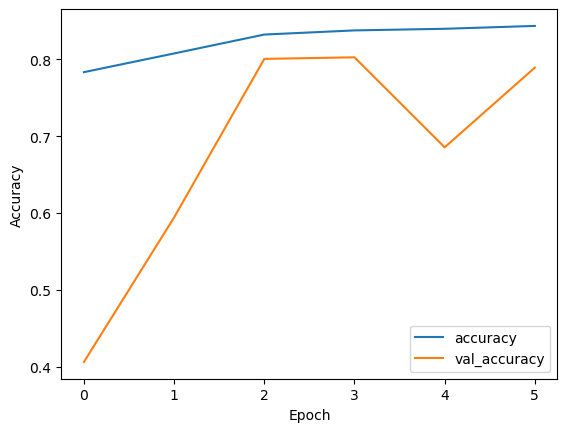

In [29]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [12]:
# Set training parameters

# Batch the images
train_ds = train_ds.batch(train_batch_size)
val_ds = val_ds.batch(val_batch_size)
# Prefetch one batch to make sure that a batch is ready to be served at all time
train_ds = train_ds.prefetch(1)
val_ds = val_ds.prefetch(1)

# Model parameters
IMAGE_SIZE = 96
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

In [13]:
# Model sturcture

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization (Batch  (None, 92, 92, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_ds, steps_per_epoch=train_steps, 
    validation_data=val_ds,
    validation_steps=val_steps,
    epochs=13,
    callbacks=[reducel, earlystopper])

Epoch 1/13


/var/folders/3n/kj5jy7_n22732qwkz2dyhyj40000gn/T/ipykernel_6540/457121911.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_ds, steps_per_epoch=train_steps,
2023-11-09 21:10:11.815188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8189

2023-11-09 21:16:44.683894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 420s 75ms/step - loss: 0.4124 - accuracy: 0.8189 - val_loss: 0.3392 - val_accuracy: 0.8569 - lr: 0.0100
Epoch 2/13
5501/5501 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8632
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
5501/5501 [==============================] - 417s 76ms/step - loss: 0.3292 - accuracy: 0.8632 - val_loss: 0.8192 - val_accuracy: 0.6859 - lr: 0.0100
Epoch 3/13
5501/5501 [==============================] - 407s 74ms/step - loss: 0.2748 - accuracy: 0.8883 - val_loss: 0.3010 - val_accuracy: 0.8760 - lr: 1.0000e-03
Epoch 4/13
5501/5501 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8935
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
5501/5501 [==============================] - 405s 74ms/step - loss: 0.2658 - accuracy: 0.8935 - val_loss: 0.3034 - val_accuracy: 0.8677 - lr: 1.0000e-03
Epoch 5/13
5501/5501 [===============

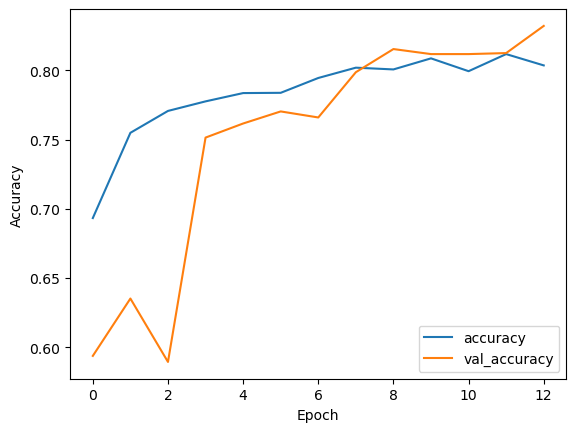

In [24]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

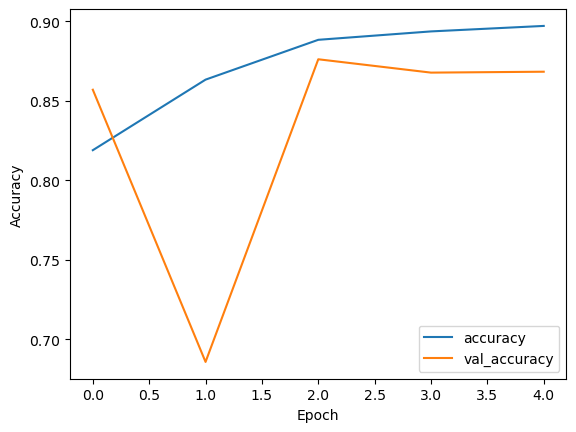

In [15]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [62]:
test_class = [label for image, label in test_ds]

In [67]:
num_val_samples

44005

In [68]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# import matplotlib.pyplot as plt

# # make a prediction
y_pred_keras = model.predict_generator(test_ds.batch(1), steps=num_val_samples, verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_class, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

   15/44005 [..............................] - ETA: 5:26 

/var/folders/3n/kj5jy7_n22732qwkz2dyhyj40000gn/T/ipykernel_6540/2095207151.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_ds.batch(1), steps=num_val_samples, verbose=1)


44005/44005 [==============================] - 154s 4ms/step


0.960620663037167

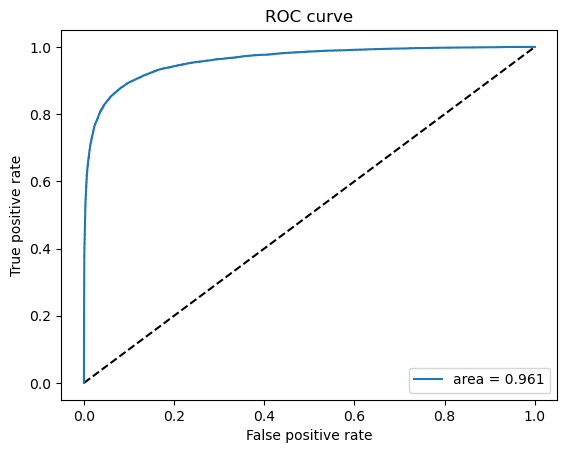

In [69]:
# Plot ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Dev

#### Read .tiff using tensorflow

In [ ]:
i = tf.io.read_file(img_path[0])
img_ = tfio.experimental.image.decode_tiff(i,)
img_ = tfio.experimental.color.rgba_to_rgb(img_)
# img_ = tfio.experimental.image.decode_tiff(i, channel=3)
type(img_)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
i = tf.io.read_file(test_img_path[0])
img_ = tfio.experimental.image.decode_tiff(i,)
# img_ = tfio.experimental.color.rgba_to_rgb(img_)
# Since decode_tiff() returns RGBA tensor, and we only need 3 channel, we just extract RGB from the tensor
r, g, b = img_[:, :, 0], img_[:, :, 1], img_[:, :, 2]
# Combine RGB together
img_ = tf.stack([r, g, b], axis = -1) # -1 means last dimension
# Standardize, convert to float values in [0, 1]
img_ = tf.image.convert_image_dtype(img_, tf.float32)
# img_ = tfio.experimental.image.decode_tiff(i, channel=3)
type(img_)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
img_

<tf.Tensor: shape=(96, 96, 3), dtype=float32, numpy=
array([[[0.627451  , 0.38431376, 0.6313726 ],
        [0.72156864, 0.40000004, 0.6901961 ],
        [0.77647066, 0.38431376, 0.72156864],
        ...,
        [0.7568628 , 0.5176471 , 0.79215693],
        [0.78823537, 0.54509807, 0.83921576],
        [0.4039216 , 0.15294118, 0.45882356]],

       [[0.6039216 , 0.40000004, 0.65882355],
        [0.70980394, 0.427451  , 0.7176471 ],
        [0.74509805, 0.40000004, 0.7372549 ],
        ...,
        [0.882353  , 0.6392157 , 0.90196085],
        [0.7568628 , 0.50980395, 0.78823537],
        [0.854902  , 0.60784316, 0.8862746 ]],

       [[0.5882353 , 0.40784317, 0.6901961 ],
        [0.6156863 , 0.38823533, 0.6901961 ],
        [0.49411768, 0.21960786, 0.5568628 ],
        ...,
        [0.85098046, 0.6       , 0.83921576],
        [0.78823537, 0.53333336, 0.7843138 ],
        [0.65882355, 0.4039216 , 0.6627451 ]],

       ...,

       [[0.7686275 , 0.43137258, 0.7254902 ],
        [0.8431

#### Build an image data pipeline

In [ ]:
### Dev: Building an image data pipeline

# Create the dataset from slices of the filenames and labels
dataset = tf.data.Dataset.from_tensor_slices((img_path, labels))
# Shuffle the data with a buffer size equal to the length of the dataset. This ensures good shuffling
dataset = dataset.shuffle(image_count)
# Parse the images from filename to the pixel values.
dataset = dataset.map(parse_function, num_parallel_calls = 4) # Use multiple threads to improve the speed of preprocessing
# Data augmentation
dataset = dataset.map(train_preprocess, num_parallel_calls = 4)
# Batch the images
batch_size = 32
dataset = dataset.batch(batch_size)
# Prefetch one batch to make sure that a batch is ready to be served at all time
dataset = dataset.prefetch(1)

2023-11-04 15:07:36.955284: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-04 15:07:36.955333: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-04 15:07:36.955351: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-04 15:07:36.955439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-04 15:07:36.955556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (96, 96, 3)
Label:  0


## Test

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

In [7]:
data_dir = Path(archive).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [8]:
data_dir/'*/*'

PosixPath('/home/ivan/.keras/datasets/flower_photos/*/*')

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

2023-10-16 11:06:42.842298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-16 11:06:42.883470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-16 11:06:42.883607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/ivan/.keras/datasets/flower_photos/tulips/14078067903_92f5eb27ff.jpg'
b'/home/ivan/.keras/datasets/flower_photos/dandelion/4489359360_09db62f825.jpg'
b'/home/ivan/.keras/datasets/flower_photos/dandelion/4721773235_429acdf496_n.jpg'
b'/home/ivan/.keras/datasets/flower_photos/tulips/6982913043_3b873c6a25.jpg'
b'/home/ivan/.keras/datasets/flower_photos/roses/3104672186_5f75647448_n.jpg'


In [108]:
type(train_ds)

tensorflow.python.data.ops.skip_op._SkipDataset

In [11]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [107]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [13]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [46]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [48]:
class_dic = {v : k for k, v in enumerate(class_names)}
class_dic

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [149]:
tf.compat.v1.enable_eager_execution()
def get_label(file_path):
  # print(type(file_path))

  # print("file_path: ",bytes.decode(file_path.numpy()), type(bytes.decode(file_path.numpy())))
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # print(tf.strings.regex_full_match([parts], r'[^\/]+(?=\.)'))
  # print(tf.keras.backend.eval(parts[-2]))
  
  print(file_path.numpy())
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # print(tf.get_static_value(one_hot, partial=True))

  # print(set(class_names) - set(parts[-2]))
  # print(bytes.decode(tf.strings.as_string(parts[-2])))
  # print((tf.strings.as_string(parts[-2])).graph)
  # print(one_hot)
  # Integer encode the label
  # print(tf.print(tf.argmax(one_hot)))
  return tf.argmax(one_hot)

In [24]:
batch_size = 32
img_height = 180
img_width = 180

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [150]:
# AUTOTUNE = tf.data.AUTOTUNE

train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

AttributeError: in user code:

    File "/tmp/ipykernel_5131/4006895522.py", line 2, in process_path  *
        label = get_label(file_path)
    File "/tmp/ipykernel_5131/1654943015.py", line 11, in get_label  *
        print(file_path.numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [53]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [55]:
print(label)

tf.Tensor(3, shape=(), dtype=int64)
